## Trigger Word Detection - Chimp Call


In [1]:
import numpy as np
from pydub import AudioSegment
import random
import sys
import io
import os
import glob
import IPython
from td_utils import *
%matplotlib inline

#  Data synthesis


##  Listening to the data   


In [2]:
IPython.display.Audio("./raw_data/activates/activates_mono_06.wav")

In [3]:
IPython.display.Audio("./raw_data/negatives/dogbark_mono_13.wav")

In [4]:
IPython.display.Audio("./raw_data/backgrounds/SENSOR211-150717100430156781960-0529.79868-03033.29254-16000KHz_00.wav")

We can create the labelled dataset using these examples

##  From audio recordings to spectrograms
 

In [8]:
#change after creating training set
IPython.display.Audio("audio_examples/SENSOR211-160717093059501559670-0529.79880-03033.29281-16000KHz_35.wav")

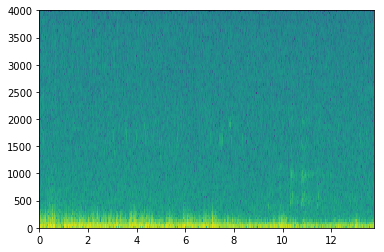

In [10]:
x = graph_spectrogram("audio_examples/SENSOR211-160717093059501559670-0529.79880-03033.29281-16000KHz_35.wav")

The dimension of the output spectrogram depends upon the hyperparameters of the spectrogram software and the length of the input. In this notebook, we will be working with 10 second audio clips as the "standard length" for our training examples. The number of timesteps of the spectrogram will be 1376. You'll see later that the spectrogram will be the input x into the network, and so T_x = 1376.


In [12]:
_, data = wavfile.read("audio_examples/SENSOR211-160717093059501559670-0529.79880-03033.29281-16000KHz_35.wav")
print("Time steps in audio recording before spectrogram", data[:].shape)
print("Time steps in input after spectrogram", x.shape)


Time steps in audio recording before spectrogram (110250,)
Time steps in input after spectrogram (101, 1376)


Now, you can define:

In [14]:
Tx = 1376 # The number of time steps input to the model from the spectrogram
n_freq = 101 # Number of frequencies input to the model at each time step of the spectrogram

In [15]:
Ty = 341 # The number of time steps in the output of our model

## Generating a single training example

- Pick a random 10 second background audio clip
- Randomly insert 0-4 audio clips of "activate" into this 10sec clip
- Randomly insert 0-2 audio clips of negative words into this 10sec clip


In [16]:
# Load audio segments using pydub 
activates, negatives, backgrounds = load_raw_audio()

print("background len: " + str(len(backgrounds[0])))    # Should be 10,000, since it is a 10 sec clip
print("activate[0] len: " + str(len(activates[0])))     # Maybe around 1000, since an "activate" audio clip is usually around 1 sec (but varies a lot)
print("activate[1] len: " + str(len(activates[1])))     # Different "activate" clips can have different lengths 

background len: 10000
activate[0] len: 1000
activate[1] len: 1000


**Overlaying positive/negative words on the background**:


**Creating the labels at the same time you overlay**:


The function `get_random_time_segment(segment_ms)` returns a random time segment onto which we can insert an audio clip of duration `segment_ms`.


In [17]:
def get_random_time_segment(segment_ms):
    """
    Gets a random time segment of duration segment_ms in a 10,000 ms audio clip.    
    Arguments:
    segment_ms -- the duration of the audio clip in ms ("ms" stands for "milliseconds")    
    Returns:
    segment_time -- a tuple of (segment_start, segment_end) in ms
    """    
    segment_start = np.random.randint(low=0, high=10000-segment_ms)   # Make sure segment doesn't run past the 10sec background 
    segment_end = segment_start + segment_ms - 1
    
    return (segment_start, segment_end)


**Check for no overlkaps**

In [18]:

def is_overlapping(segment_time, previous_segments):
    """
    Checks if the time of a segment overlaps with the times of existing segments.    
    Arguments:
    segment_time -- a tuple of (segment_start, segment_end) for the new segment
    previous_segments -- a list of tuples of (segment_start, segment_end) for the existing segments    
    Returns:
    True if the time segment overlaps with any of the existing segments, False otherwise
    """    
    segment_start, segment_end = segment_time    
    overlap = False
    for previous_start, previous_end in previous_segments:
        if segment_start <= previous_end and segment_end >= previous_start:
            overlap = True

    return overlap

In [19]:
overlap1 = is_overlapping((950, 1430), [(2000, 2550), (260, 949)])
overlap2 = is_overlapping((2305, 2950), [(824, 1532), (1900, 2305), (3424, 3656)])
print("Overlap 1 = ", overlap1)
print("Overlap 2 = ", overlap2)

Overlap 1 =  False
Overlap 2 =  True



**Overlaying audio clip**

1. Get a random time segment of the right duration in ms.
2. Make sure that the time segment does not overlap with any of the previous time segments. If it is overlapping, then go back to step 1 and pick a new time segment.
3. Add the new time segment to the list of existing time segments, so as to keep track of all the segments you've inserted.  
4. Overlay the audio clip over the background using pydub. We have implemented this for you.

In [20]:
def insert_audio_clip(background, audio_clip, previous_segments):
    """
    Insert a new audio segment over the background noise at a random time step, ensuring that the 
    audio segment does not overlap with existing segments.    
    Arguments:
    background -- a 10 second background audio recording.  
    audio_clip -- the audio clip to be inserted/overlaid. 
    previous_segments -- times where audio segments have already been placed    
    Returns:
    new_background -- the updated background audio
    """
    segment_ms = len(audio_clip)    
    segment_time = get_random_time_segment(segment_ms)
    
    while is_overlapping(segment_time, previous_segments):
        segment_time = segment_time = get_random_time_segment(segment_ms)

    previous_segments.append(segment_time)
    
    new_background = background.overlay(audio_clip, position = segment_time[0])
    
    return new_background, segment_time

In [21]:
np.random.seed(5)
audio_clip, segment_time = insert_audio_clip(backgrounds[0], activates[0], [(3790, 4400)])
audio_clip.export("insert_test.wav", format="wav")
print("Segment Time: ", segment_time)
IPython.display.Audio("insert_test.wav")

Segment Time:  (2254, 3253)


In [22]:
# Expected audio
IPython.display.Audio("audio_examples/insert_reference.wav")

**Update Labels Ty**

In [59]:
def insert_ones(y, segment_end_ms):
    """
    Update the label vector y. The labels of the 10 output steps strictly after the end of the segment 
    should be set to 1. By strictly we mean that the label of segment_end_y should be 0 while, the
    10 followinf labels should be ones.    
    Arguments:
    y -- numpy array of shape (1, Ty), the labels of the training example
    segment_end_ms -- the end time of the segment in ms    
    Returns:
    y -- updated labels
    """

    segment_end_y = int(segment_end_ms * Ty / 10000.0)
    
    for i in range(segment_end_y + 1, segment_end_y + 11):
        if i < Ty:
            y[0, i] =1
    
    return y

sanity checks: 1.0 0.0 0.0


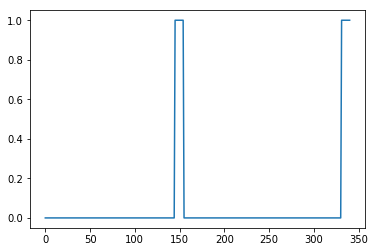

In [62]:
arr1 = insert_ones(np.zeros((1, Ty)), 9700)
plt.plot(insert_ones(arr1, 4251)[0,:])
print("sanity checks:", arr1[0][150], arr1[0][10], arr1[0][65])

**Create a single training example**

1. Initialize the label vector $y$ as a numpy array of zeros and shape $(1, T_y)$.
2. Initialize the set of existing segments to an empty list.
3. Randomly select 0 to 4 "activate" audio clips, and insert them onto the 10sec clip. Also insert labels at the correct position in the label vector $y$.
4. Randomly select 0 to 2 negative audio clips, and insert them into the 10sec clip. 


In [25]:
def create_training_example(background, activates, negatives, i):
    """
    Creates a training example with a given background, activates, and negatives.   
    Arguments:
    background -- a 10 second background audio recording
    activates -- a list of audio segments of the word "activate"
    negatives -- a list of audio segments of random words that are not "activate"
    Returns:
    x -- the spectrogram of the training example
    y -- the label at each time step of the spectrogram
    """
    #background = background - 20
    y = np.zeros((1, Ty))
    previous_segments = []

    # Select 0-4 random chimp audio clips from activates
    number_of_activates = np.random.randint(0, 5)
    random_indices = np.random.randint(len(activates), size=number_of_activates)
    random_activates = [activates[i] for i in random_indices]

    # Insert activates
    for random_activate in random_activates:
        background, segment_time = insert_audio_clip(background, random_activate, previous_segments)
        segment_start, segment_end = segment_time
        y = insert_ones(y, segment_end_ms=segment_end)

    number_of_negatives = np.random.randint(0, 3)
    random_indices = np.random.randint(len(negatives), size=number_of_negatives)
    random_negatives = [negatives[i] for i in random_indices]

    # Insert negatives
    for random_negative in random_negatives:
        background, _ = insert_audio_clip(background, random_negative, previous_segments)

    # Standardize the volume of the audio clip 
    background = match_target_amplitude(background, -20.0)

    # Export new training example 
    file_handle = background.export("D:\Thesis\Trigger word model - chimps\synthetic_train/train" + str(i) + ".wav", format="wav")
    print("File (train"+ str(i) +".wav) was saved in your directory.")
    
    x = graph_spectrogram("train.wav")
    
    return x, y

## Full training set

File (train0.wav) was saved in your directory.
File (train1.wav) was saved in your directory.
File (train2.wav) was saved in your directory.
File (train3.wav) was saved in your directory.
File (train4.wav) was saved in your directory.
File (train5.wav) was saved in your directory.
File (train6.wav) was saved in your directory.
File (train7.wav) was saved in your directory.
File (train8.wav) was saved in your directory.
File (train9.wav) was saved in your directory.
File (train10.wav) was saved in your directory.
File (train11.wav) was saved in your directory.
File (train12.wav) was saved in your directory.
File (train13.wav) was saved in your directory.
File (train14.wav) was saved in your directory.
File (train15.wav) was saved in your directory.
File (train16.wav) was saved in your directory.
File (train17.wav) was saved in your directory.
File (train18.wav) was saved in your directory.
File (train19.wav) was saved in your directory.
File (train20.wav) was saved in your directory.
Fi

File (train175.wav) was saved in your directory.
File (train176.wav) was saved in your directory.
File (train177.wav) was saved in your directory.
File (train178.wav) was saved in your directory.
File (train179.wav) was saved in your directory.
File (train180.wav) was saved in your directory.
File (train181.wav) was saved in your directory.
File (train182.wav) was saved in your directory.
File (train183.wav) was saved in your directory.
File (train184.wav) was saved in your directory.
File (train185.wav) was saved in your directory.
File (train186.wav) was saved in your directory.
File (train187.wav) was saved in your directory.
File (train188.wav) was saved in your directory.
File (train189.wav) was saved in your directory.
File (train190.wav) was saved in your directory.
File (train191.wav) was saved in your directory.
File (train192.wav) was saved in your directory.
File (train193.wav) was saved in your directory.
File (train194.wav) was saved in your directory.
File (train195.wav) 

File (train347.wav) was saved in your directory.
File (train348.wav) was saved in your directory.
File (train349.wav) was saved in your directory.
File (train350.wav) was saved in your directory.
File (train351.wav) was saved in your directory.
File (train352.wav) was saved in your directory.
File (train353.wav) was saved in your directory.
File (train354.wav) was saved in your directory.
File (train355.wav) was saved in your directory.
File (train356.wav) was saved in your directory.
File (train357.wav) was saved in your directory.
File (train358.wav) was saved in your directory.
File (train359.wav) was saved in your directory.
File (train360.wav) was saved in your directory.
File (train361.wav) was saved in your directory.
File (train362.wav) was saved in your directory.
File (train363.wav) was saved in your directory.
File (train364.wav) was saved in your directory.
File (train365.wav) was saved in your directory.
File (train366.wav) was saved in your directory.
File (train367.wav) 

File (train516.wav) was saved in your directory.
File (train517.wav) was saved in your directory.
File (train518.wav) was saved in your directory.
File (train519.wav) was saved in your directory.
File (train520.wav) was saved in your directory.
File (train521.wav) was saved in your directory.
File (train522.wav) was saved in your directory.
File (train523.wav) was saved in your directory.
File (train524.wav) was saved in your directory.
File (train525.wav) was saved in your directory.
File (train526.wav) was saved in your directory.
File (train527.wav) was saved in your directory.
File (train528.wav) was saved in your directory.
File (train529.wav) was saved in your directory.
File (train530.wav) was saved in your directory.
File (train531.wav) was saved in your directory.
File (train532.wav) was saved in your directory.
File (train533.wav) was saved in your directory.
File (train534.wav) was saved in your directory.
File (train535.wav) was saved in your directory.
File (train536.wav) 

File (train685.wav) was saved in your directory.
File (train686.wav) was saved in your directory.
File (train687.wav) was saved in your directory.
File (train688.wav) was saved in your directory.
File (train689.wav) was saved in your directory.
File (train690.wav) was saved in your directory.
File (train691.wav) was saved in your directory.
File (train692.wav) was saved in your directory.
File (train693.wav) was saved in your directory.
File (train694.wav) was saved in your directory.
File (train695.wav) was saved in your directory.
File (train696.wav) was saved in your directory.
File (train697.wav) was saved in your directory.
File (train698.wav) was saved in your directory.
File (train699.wav) was saved in your directory.
File (train700.wav) was saved in your directory.
File (train701.wav) was saved in your directory.
File (train702.wav) was saved in your directory.
File (train703.wav) was saved in your directory.
File (train704.wav) was saved in your directory.
File (train705.wav) 

File (train858.wav) was saved in your directory.
File (train859.wav) was saved in your directory.
File (train860.wav) was saved in your directory.
File (train861.wav) was saved in your directory.
File (train862.wav) was saved in your directory.
File (train863.wav) was saved in your directory.
File (train864.wav) was saved in your directory.
File (train865.wav) was saved in your directory.
File (train866.wav) was saved in your directory.
File (train867.wav) was saved in your directory.
File (train868.wav) was saved in your directory.
File (train869.wav) was saved in your directory.
File (train870.wav) was saved in your directory.
File (train871.wav) was saved in your directory.
File (train872.wav) was saved in your directory.
File (train873.wav) was saved in your directory.
File (train874.wav) was saved in your directory.
File (train875.wav) was saved in your directory.
File (train876.wav) was saved in your directory.
File (train877.wav) was saved in your directory.
File (train878.wav) 

File (train1025.wav) was saved in your directory.
File (train1026.wav) was saved in your directory.
File (train1027.wav) was saved in your directory.
File (train1028.wav) was saved in your directory.
File (train1029.wav) was saved in your directory.
File (train1030.wav) was saved in your directory.
File (train1031.wav) was saved in your directory.
File (train1032.wav) was saved in your directory.
File (train1033.wav) was saved in your directory.
File (train1034.wav) was saved in your directory.
File (train1035.wav) was saved in your directory.
File (train1036.wav) was saved in your directory.
File (train1037.wav) was saved in your directory.
File (train1038.wav) was saved in your directory.
File (train1039.wav) was saved in your directory.
File (train1040.wav) was saved in your directory.
File (train1041.wav) was saved in your directory.
File (train1042.wav) was saved in your directory.
File (train1043.wav) was saved in your directory.
File (train1044.wav) was saved in your directory.


File (train1191.wav) was saved in your directory.
File (train1192.wav) was saved in your directory.
File (train1193.wav) was saved in your directory.
File (train1194.wav) was saved in your directory.
File (train1195.wav) was saved in your directory.
File (train1196.wav) was saved in your directory.
File (train1197.wav) was saved in your directory.
File (train1198.wav) was saved in your directory.
File (train1199.wav) was saved in your directory.
File (train1200.wav) was saved in your directory.
File (train1201.wav) was saved in your directory.
File (train1202.wav) was saved in your directory.
File (train1203.wav) was saved in your directory.
File (train1204.wav) was saved in your directory.
File (train1205.wav) was saved in your directory.
File (train1206.wav) was saved in your directory.
File (train1207.wav) was saved in your directory.
File (train1208.wav) was saved in your directory.
File (train1209.wav) was saved in your directory.
File (train1210.wav) was saved in your directory.


File (train1355.wav) was saved in your directory.
File (train1356.wav) was saved in your directory.
File (train1357.wav) was saved in your directory.
File (train1358.wav) was saved in your directory.
File (train1359.wav) was saved in your directory.
File (train1360.wav) was saved in your directory.
File (train1361.wav) was saved in your directory.
File (train1362.wav) was saved in your directory.
File (train1363.wav) was saved in your directory.
File (train1364.wav) was saved in your directory.
File (train1365.wav) was saved in your directory.
File (train1366.wav) was saved in your directory.
File (train1367.wav) was saved in your directory.
File (train1368.wav) was saved in your directory.
File (train1369.wav) was saved in your directory.
File (train1370.wav) was saved in your directory.
File (train1371.wav) was saved in your directory.
File (train1372.wav) was saved in your directory.
File (train1373.wav) was saved in your directory.
File (train1374.wav) was saved in your directory.


File (train1522.wav) was saved in your directory.
File (train1523.wav) was saved in your directory.
File (train1524.wav) was saved in your directory.
File (train1525.wav) was saved in your directory.
File (train1526.wav) was saved in your directory.
File (train1527.wav) was saved in your directory.
File (train1528.wav) was saved in your directory.
File (train1529.wav) was saved in your directory.
File (train1530.wav) was saved in your directory.
File (train1531.wav) was saved in your directory.
File (train1532.wav) was saved in your directory.
File (train1533.wav) was saved in your directory.
File (train1534.wav) was saved in your directory.
File (train1535.wav) was saved in your directory.
File (train1536.wav) was saved in your directory.
File (train1537.wav) was saved in your directory.
File (train1538.wav) was saved in your directory.
File (train1539.wav) was saved in your directory.
File (train1540.wav) was saved in your directory.
File (train1541.wav) was saved in your directory.


File (train1688.wav) was saved in your directory.
File (train1689.wav) was saved in your directory.
File (train1690.wav) was saved in your directory.
File (train1691.wav) was saved in your directory.
File (train1692.wav) was saved in your directory.
File (train1693.wav) was saved in your directory.
File (train1694.wav) was saved in your directory.
File (train1695.wav) was saved in your directory.
File (train1696.wav) was saved in your directory.
File (train1697.wav) was saved in your directory.
File (train1698.wav) was saved in your directory.
File (train1699.wav) was saved in your directory.
File (train1700.wav) was saved in your directory.
File (train1701.wav) was saved in your directory.
File (train1702.wav) was saved in your directory.
File (train1703.wav) was saved in your directory.
File (train1704.wav) was saved in your directory.
File (train1705.wav) was saved in your directory.
File (train1706.wav) was saved in your directory.
File (train1707.wav) was saved in your directory.


File (train1853.wav) was saved in your directory.
File (train1854.wav) was saved in your directory.
File (train1855.wav) was saved in your directory.
File (train1856.wav) was saved in your directory.
File (train1857.wav) was saved in your directory.
File (train1858.wav) was saved in your directory.
File (train1859.wav) was saved in your directory.
File (train1860.wav) was saved in your directory.
File (train1861.wav) was saved in your directory.
File (train1862.wav) was saved in your directory.
File (train1863.wav) was saved in your directory.
File (train1864.wav) was saved in your directory.
File (train1865.wav) was saved in your directory.
File (train1866.wav) was saved in your directory.
File (train1867.wav) was saved in your directory.
File (train1868.wav) was saved in your directory.
File (train1869.wav) was saved in your directory.
File (train1870.wav) was saved in your directory.
File (train1871.wav) was saved in your directory.
File (train1872.wav) was saved in your directory.


File (train2017.wav) was saved in your directory.
File (train2018.wav) was saved in your directory.
File (train2019.wav) was saved in your directory.
File (train2020.wav) was saved in your directory.
File (train2021.wav) was saved in your directory.
File (train2022.wav) was saved in your directory.
File (train2023.wav) was saved in your directory.
File (train2024.wav) was saved in your directory.
File (train2025.wav) was saved in your directory.
File (train2026.wav) was saved in your directory.
File (train2027.wav) was saved in your directory.
File (train2028.wav) was saved in your directory.
File (train2029.wav) was saved in your directory.
File (train2030.wav) was saved in your directory.
File (train2031.wav) was saved in your directory.
File (train2032.wav) was saved in your directory.
File (train2033.wav) was saved in your directory.
File (train2034.wav) was saved in your directory.
File (train2035.wav) was saved in your directory.
File (train2036.wav) was saved in your directory.


File (train2183.wav) was saved in your directory.
File (train2184.wav) was saved in your directory.
File (train2185.wav) was saved in your directory.
File (train2186.wav) was saved in your directory.
File (train2187.wav) was saved in your directory.
File (train2188.wav) was saved in your directory.
File (train2189.wav) was saved in your directory.
File (train2190.wav) was saved in your directory.
File (train2191.wav) was saved in your directory.
File (train2192.wav) was saved in your directory.
File (train2193.wav) was saved in your directory.
File (train2194.wav) was saved in your directory.
File (train2195.wav) was saved in your directory.
File (train2196.wav) was saved in your directory.
File (train2197.wav) was saved in your directory.
File (train2198.wav) was saved in your directory.
File (train2199.wav) was saved in your directory.
File (train2200.wav) was saved in your directory.
File (train2201.wav) was saved in your directory.
File (train2202.wav) was saved in your directory.


File (train2348.wav) was saved in your directory.
File (train2349.wav) was saved in your directory.
File (train2350.wav) was saved in your directory.
File (train2351.wav) was saved in your directory.
File (train2352.wav) was saved in your directory.
File (train2353.wav) was saved in your directory.
File (train2354.wav) was saved in your directory.
File (train2355.wav) was saved in your directory.
File (train2356.wav) was saved in your directory.
File (train2357.wav) was saved in your directory.
File (train2358.wav) was saved in your directory.
File (train2359.wav) was saved in your directory.
File (train2360.wav) was saved in your directory.
File (train2361.wav) was saved in your directory.
File (train2362.wav) was saved in your directory.
File (train2363.wav) was saved in your directory.
File (train2364.wav) was saved in your directory.
File (train2365.wav) was saved in your directory.
File (train2366.wav) was saved in your directory.
File (train2367.wav) was saved in your directory.


File (train2512.wav) was saved in your directory.
File (train2513.wav) was saved in your directory.
File (train2514.wav) was saved in your directory.
File (train2515.wav) was saved in your directory.
File (train2516.wav) was saved in your directory.
File (train2517.wav) was saved in your directory.
File (train2518.wav) was saved in your directory.
File (train2519.wav) was saved in your directory.
File (train2520.wav) was saved in your directory.
File (train2521.wav) was saved in your directory.
File (train2522.wav) was saved in your directory.
File (train2523.wav) was saved in your directory.
File (train2524.wav) was saved in your directory.
File (train2525.wav) was saved in your directory.
File (train2526.wav) was saved in your directory.
File (train2527.wav) was saved in your directory.
File (train2528.wav) was saved in your directory.
File (train2529.wav) was saved in your directory.
File (train2530.wav) was saved in your directory.
File (train2531.wav) was saved in your directory.


File (train2677.wav) was saved in your directory.
File (train2678.wav) was saved in your directory.
File (train2679.wav) was saved in your directory.
File (train2680.wav) was saved in your directory.
File (train2681.wav) was saved in your directory.
File (train2682.wav) was saved in your directory.
File (train2683.wav) was saved in your directory.
File (train2684.wav) was saved in your directory.
File (train2685.wav) was saved in your directory.
File (train2686.wav) was saved in your directory.
File (train2687.wav) was saved in your directory.
File (train2688.wav) was saved in your directory.
File (train2689.wav) was saved in your directory.
File (train2690.wav) was saved in your directory.
File (train2691.wav) was saved in your directory.
File (train2692.wav) was saved in your directory.
File (train2693.wav) was saved in your directory.
File (train2694.wav) was saved in your directory.
File (train2695.wav) was saved in your directory.
File (train2696.wav) was saved in your directory.


File (train2843.wav) was saved in your directory.
File (train2844.wav) was saved in your directory.
File (train2845.wav) was saved in your directory.
File (train2846.wav) was saved in your directory.
File (train2847.wav) was saved in your directory.
File (train2848.wav) was saved in your directory.
File (train2849.wav) was saved in your directory.
File (train2850.wav) was saved in your directory.
File (train2851.wav) was saved in your directory.
File (train2852.wav) was saved in your directory.
File (train2853.wav) was saved in your directory.
File (train2854.wav) was saved in your directory.
File (train2855.wav) was saved in your directory.
File (train2856.wav) was saved in your directory.
File (train2857.wav) was saved in your directory.
File (train2858.wav) was saved in your directory.
File (train2859.wav) was saved in your directory.
File (train2860.wav) was saved in your directory.
File (train2861.wav) was saved in your directory.
File (train2862.wav) was saved in your directory.


File (train3007.wav) was saved in your directory.
File (train3008.wav) was saved in your directory.
File (train3009.wav) was saved in your directory.
File (train3010.wav) was saved in your directory.
File (train3011.wav) was saved in your directory.
File (train3012.wav) was saved in your directory.
File (train3013.wav) was saved in your directory.
File (train3014.wav) was saved in your directory.
File (train3015.wav) was saved in your directory.
File (train3016.wav) was saved in your directory.
File (train3017.wav) was saved in your directory.
File (train3018.wav) was saved in your directory.
File (train3019.wav) was saved in your directory.
File (train3020.wav) was saved in your directory.
File (train3021.wav) was saved in your directory.
File (train3022.wav) was saved in your directory.
File (train3023.wav) was saved in your directory.
File (train3024.wav) was saved in your directory.
File (train3025.wav) was saved in your directory.
File (train3026.wav) was saved in your directory.


File (train3171.wav) was saved in your directory.
File (train3172.wav) was saved in your directory.
File (train3173.wav) was saved in your directory.
File (train3174.wav) was saved in your directory.
File (train3175.wav) was saved in your directory.
File (train3176.wav) was saved in your directory.
File (train3177.wav) was saved in your directory.
File (train3178.wav) was saved in your directory.
File (train3179.wav) was saved in your directory.
File (train3180.wav) was saved in your directory.
File (train3181.wav) was saved in your directory.
File (train3182.wav) was saved in your directory.
File (train3183.wav) was saved in your directory.
File (train3184.wav) was saved in your directory.
File (train3185.wav) was saved in your directory.
File (train3186.wav) was saved in your directory.
File (train3187.wav) was saved in your directory.
File (train3188.wav) was saved in your directory.
File (train3189.wav) was saved in your directory.
File (train3190.wav) was saved in your directory.


File (train3335.wav) was saved in your directory.
File (train3336.wav) was saved in your directory.
File (train3337.wav) was saved in your directory.
File (train3338.wav) was saved in your directory.
File (train3339.wav) was saved in your directory.
File (train3340.wav) was saved in your directory.
File (train3341.wav) was saved in your directory.
File (train3342.wav) was saved in your directory.
File (train3343.wav) was saved in your directory.
File (train3344.wav) was saved in your directory.
File (train3345.wav) was saved in your directory.
File (train3346.wav) was saved in your directory.
File (train3347.wav) was saved in your directory.
File (train3348.wav) was saved in your directory.
File (train3349.wav) was saved in your directory.
File (train3350.wav) was saved in your directory.
File (train3351.wav) was saved in your directory.
File (train3352.wav) was saved in your directory.
File (train3353.wav) was saved in your directory.
File (train3354.wav) was saved in your directory.


File (train3500.wav) was saved in your directory.
File (train3501.wav) was saved in your directory.
File (train3502.wav) was saved in your directory.
File (train3503.wav) was saved in your directory.
File (train3504.wav) was saved in your directory.
File (train3505.wav) was saved in your directory.
File (train3506.wav) was saved in your directory.
File (train3507.wav) was saved in your directory.
File (train3508.wav) was saved in your directory.
File (train3509.wav) was saved in your directory.
File (train3510.wav) was saved in your directory.
File (train3511.wav) was saved in your directory.
File (train3512.wav) was saved in your directory.
File (train3513.wav) was saved in your directory.
File (train3514.wav) was saved in your directory.
File (train3515.wav) was saved in your directory.
File (train3516.wav) was saved in your directory.
File (train3517.wav) was saved in your directory.
File (train3518.wav) was saved in your directory.
File (train3519.wav) was saved in your directory.


File (train3664.wav) was saved in your directory.
File (train3665.wav) was saved in your directory.
File (train3666.wav) was saved in your directory.
File (train3667.wav) was saved in your directory.
File (train3668.wav) was saved in your directory.
File (train3669.wav) was saved in your directory.
File (train3670.wav) was saved in your directory.
File (train3671.wav) was saved in your directory.
File (train3672.wav) was saved in your directory.
File (train3673.wav) was saved in your directory.
File (train3674.wav) was saved in your directory.
File (train3675.wav) was saved in your directory.
File (train3676.wav) was saved in your directory.
File (train3677.wav) was saved in your directory.
File (train3678.wav) was saved in your directory.
File (train3679.wav) was saved in your directory.
File (train3680.wav) was saved in your directory.
File (train3681.wav) was saved in your directory.
File (train3682.wav) was saved in your directory.
File (train3683.wav) was saved in your directory.


File (train3829.wav) was saved in your directory.
File (train3830.wav) was saved in your directory.
File (train3831.wav) was saved in your directory.
File (train3832.wav) was saved in your directory.
File (train3833.wav) was saved in your directory.
File (train3834.wav) was saved in your directory.
File (train3835.wav) was saved in your directory.
File (train3836.wav) was saved in your directory.
File (train3837.wav) was saved in your directory.
File (train3838.wav) was saved in your directory.
File (train3839.wav) was saved in your directory.
File (train3840.wav) was saved in your directory.
File (train3841.wav) was saved in your directory.
File (train3842.wav) was saved in your directory.
File (train3843.wav) was saved in your directory.
File (train3844.wav) was saved in your directory.
File (train3845.wav) was saved in your directory.
File (train3846.wav) was saved in your directory.
File (train3847.wav) was saved in your directory.
File (train3848.wav) was saved in your directory.


File (train3993.wav) was saved in your directory.
File (train3994.wav) was saved in your directory.
File (train3995.wav) was saved in your directory.
File (train3996.wav) was saved in your directory.
File (train3997.wav) was saved in your directory.
File (train3998.wav) was saved in your directory.
File (train3999.wav) was saved in your directory.


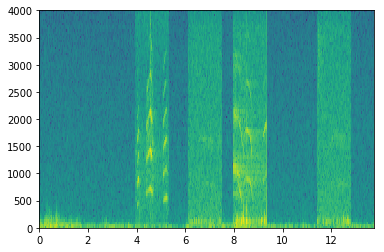

In [26]:
#create 4000 training examples
X = np.empty([4000,1376,101])
Y = np.empty([4000,341,1])
for i in range (4000):
    x, y = create_training_example(backgrounds[0], activates, negatives, i)
    X[i] = np.transpose(x)
    Y[i] = np.transpose(y)

Now you can listen to the training example you created and compare it to the spectrogram generated above.

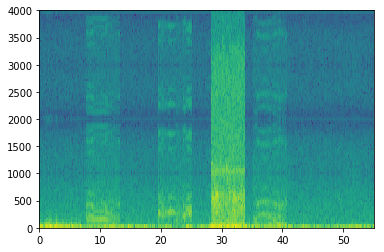

In [57]:
#X.shape
x = graph_spectrogram("synthetic_train/train48.wav")

In [58]:
IPython.display.Audio("synthetic_train/train48.wav")

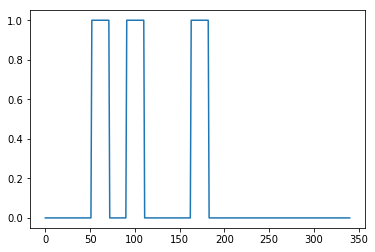

In [29]:
#IPython.display.Audio("audio_examples/train_reference.wav")
plt.plot(Y[45])

In [31]:
Y.shape

(4000, 341, 1)

In [137]:
#export data and import again
np.save("./XY_train/X.npy", X)
np.save("./XY_train/Y.npy",Y)
del X, Y

In [ ]:
X = np.load("./XY_train/X.npy")
Y = np.load("./XY_train/Y.npy")

#  Model


The model will use 1-D convolutional layers, GRU layers, and dense layers

In [32]:
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam

d:\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Model Architecture


- One key step of this model is the 1D convolutional step. It inputs the 1376 step spectrogram, and outputs a 1375 step output, which is then further processed by multiple layers to get the final T_y = 341 step output. This layer extracts low-level features and then possibly generates an output of a smaller dimension. 

- Computationally, the 1-D conv layer also helps speed up the model because now the GRU  has to process only 341 timesteps rather than 1376 timesteps. The two GRU layers read the sequence of inputs from left to right, then ultimately uses a dense+sigmoid layer to make a prediction for $Yt$. Because $y$ is binary valued (0 or 1), we use a sigmoid output at the last layer to estimate the chance of the output being 1, corresponding to the chimnp call.

- Note that we use a uni-directional RNN rather than a bi-directional RNN. This is really important for trigger word detection, since we want to be able to detect the trigger word almost immediately after it is said. If we used a bi-directional RNN, we would have to wait for the whole 10sec of audio to be recorded before we could tell if the chimp call was heard in the first second of the audio clip.  


In [33]:
def model(input_shape):
    """
    Function creating the model's graph in Keras.    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)
    Returns:
    model -- Keras model instance
    """    
    X_input = Input(shape = input_shape)
    
    # Layer 1: CONV layer 
    X = Conv1D(196, kernel_size=15, strides=4)(X_input)                
    X = BatchNormalization()(X)                                 
    X = Activation('relu')(X)                                 
    X = Dropout(0.8)(X)                                 

    # Layer 2: First GRU Layer
    X = GRU(units = 128, return_sequences = True)(X) 
    X = Dropout(0.8)(X)                                 
    X = BatchNormalization()(X)                                 
     
    # Layer 3: Second GRU Layer 
    X = GRU(units = 128, return_sequences = True)(X)  
    X = Dropout(0.8)(X)                                
    X = BatchNormalization()(X)                                  
    X = Dropout(0.8)(X)                                 
     
    # Layer 4: Time-distributed dense layer 
    X = TimeDistributed(Dense(1, activation = "sigmoid"))(X) 

    model = Model(inputs = X_input, outputs = X)    
    return model  

In [34]:
model = model(input_shape = (1376, n_freq))

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


In [35]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1376, 101)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 341, 196)          297136    
_________________________________________________________________
batch_normalization_1 (Batch (None, 341, 196)          784       
_________________________________________________________________
activation_1 (Activation)    (None, 341, 196)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 341, 196)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 341, 128)          124800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 341, 128)          0         
__________

The output of the network is of shape (None, 1375, 1) while the input is (None, 5511, 101). The Conv1D has reduced the number of steps from 5511 at spectrogram to 1375. 

Trigger word detection takes a long time to train. To save time, we've already trained a model for about 3 hours on a GPU using the architecture you built above, and a large training set of about 4000 examples. Let's load the model. 

In [36]:
model = load_model('my_model.h5')

Training the model further, using the Adam optimizer and binary cross entropy loss, as follows. This will run quickly because we are training just for one epoch and with a small training set of 25 examples. 

In [42]:
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])

In [44]:
model.fit(X, Y, batch_size = 256, epochs=1)

Epoch 1/200
4000/4000 [==============================] - 27s 7ms/step - loss: 1.0596 - acc: 0.5581
Epoch 2/200
4000/4000 [==============================] - 23s 6ms/step - loss: 1.0355 - acc: 0.5780
Epoch 3/200
4000/4000 [==============================] - 23s 6ms/step - loss: 1.0187 - acc: 0.6020
Epoch 4/200
4000/4000 [==============================] - 27s 7ms/step - loss: 1.0057 - acc: 0.6197
Epoch 5/200
4000/4000 [==============================] - 37s 9ms/step - loss: 0.9961 - acc: 0.6398
Epoch 6/200
4000/4000 [==============================] - 32s 8ms/step - loss: 0.9863 - acc: 0.6581
Epoch 7/200
4000/4000 [==============================] - 27s 7ms/step - loss: 0.9742 - acc: 0.6728
Epoch 8/200
4000/4000 [==============================] - 26s 7ms/step - loss: 0.9684 - acc: 0.6847
Epoch 9/200
4000/4000 [==============================] - 25s 6ms/step - loss: 0.9621 - acc: 0.6949
Epoch 10/200
4000/4000 [==============================] - 26s 6ms/step - loss: 0.9577 - acc: 0.7057
Epoch 11/

4000/4000 [==============================] - 21s 5ms/step - loss: 0.8168 - acc: 0.8089
Epoch 84/200
4000/4000 [==============================] - 23s 6ms/step - loss: 0.8171 - acc: 0.8090
Epoch 85/200
4000/4000 [==============================] - 24s 6ms/step - loss: 0.8151 - acc: 0.8093
Epoch 86/200
4000/4000 [==============================] - 23s 6ms/step - loss: 0.8137 - acc: 0.8098
Epoch 87/200
4000/4000 [==============================] - 23s 6ms/step - loss: 0.8145 - acc: 0.8097
Epoch 88/200
4000/4000 [==============================] - 22s 5ms/step - loss: 0.8113 - acc: 0.8103
Epoch 89/200
4000/4000 [==============================] - 21s 5ms/step - loss: 0.8102 - acc: 0.8106
Epoch 90/200
4000/4000 [==============================] - 21s 5ms/step - loss: 0.8102 - acc: 0.8105
Epoch 91/200
4000/4000 [==============================] - 21s 5ms/step - loss: 0.8086 - acc: 0.8110
Epoch 92/200
4000/4000 [==============================] - 22s 6ms/step - loss: 0.8105 - acc: 0.8110
Epoch 93/200


4000/4000 [==============================] - 21s 5ms/step - loss: 0.7737 - acc: 0.8254
Epoch 165/200
4000/4000 [==============================] - 22s 5ms/step - loss: 0.7738 - acc: 0.8252
Epoch 166/200
4000/4000 [==============================] - 22s 6ms/step - loss: 0.7740 - acc: 0.8252
Epoch 167/200
4000/4000 [==============================] - 22s 5ms/step - loss: 0.7722 - acc: 0.8255
Epoch 168/200
4000/4000 [==============================] - 21s 5ms/step - loss: 0.7734 - acc: 0.8257
Epoch 169/200
4000/4000 [==============================] - 21s 5ms/step - loss: 0.7729 - acc: 0.8251
Epoch 170/200
4000/4000 [==============================] - 21s 5ms/step - loss: 0.7727 - acc: 0.8260
Epoch 171/200
4000/4000 [==============================] - 21s 5ms/step - loss: 0.7735 - acc: 0.8256
Epoch 172/200
4000/4000 [==============================] - 22s 5ms/step - loss: 0.7717 - acc: 0.8259
Epoch 173/200
4000/4000 [==============================] - 22s 5ms/step - loss: 0.7716 - acc: 0.8261
Epoc

In [45]:
#save model
model.save('my_model.h5')

##  Testing the model - empirical

**Compute predictions**

1. Compute the spectrogram for the audio file
2. Use `np.swap` and `np.expand_dims` to reshape your input to size (1, Tx, n_freqs)
5. compute the prediction at each output step

In [79]:
def detect_triggerword(filename):
    plt.subplot(2, 1, 1)

    x = graph_spectrogram(filename)
    # the spectogram outputs (freqs, Tx) and we want (Tx, freqs) to input into the model
    x  = x.swapaxes(0,1)
    x = np.expand_dims(x, axis=0)
    #adjusting sensitivity
    predictions = 1-2.5*(model.predict(x))
#    predictions = model.predict(x)
    plt.subplot(2, 1, 2)
    plt.plot(predictions[0,:,0])
    plt.ylabel('probability')
    plt.show()
    return predictions


**Chime on activate**

1. Loop over the predicted probabilities at each output step
2. When the prediction is larger than the threshold and more than 30 consecutive time steps have passed, insert a "chime" sound onto the original audio clip


In [103]:
chime_file = "audio_examples/chime.wav"
def chime_on_activate(filename, predictions, threshold):
    
    audio_clip = AudioSegment.from_wav(filename)
    chime = AudioSegment.from_wav(chime_file)
    Ty = predictions.shape[1]
    # Step 1: Initialize the number of consecutive output steps to 0
    consecutive_timesteps = 0
    # Step 2: Loop over the output steps in the y
    
    for i in range(Ty):
        consecutive_timesteps += 1
        
        if predictions[0,i,0] > threshold and consecutive_timesteps > 30:
            audio_clip = audio_clip.overlay(chime, position = ((i / Ty) * audio_clip.duration_seconds)*1000)
            consecutive_timesteps = 0
        
    audio_clip.export("chime_output.wav", format='wav')

##  Test on dev examples : for accuracy metrics

In [104]:
# Preprocess the audio to the correct format
def preprocess_audio(filename):
    # Trim or pad audio segment to 10000ms
    padding = AudioSegment.silent(duration=10000)
    segment = AudioSegment.from_wav(filename)[:10000]
    segment = padding.overlay(segment)
    # Set frame rate to 11025
    segment = segment.set_frame_rate(11025)
    # Export as wav
    segment.export(filename, format='wav')

In [132]:
sound_filename = "audio_examples/SENSOR211-160717111111158162812-0529.79956-03033.29253-16000KHz_29.wav"

In [133]:
preprocess_audio(sound_filename)
IPython.display.Audio(your_filename) 

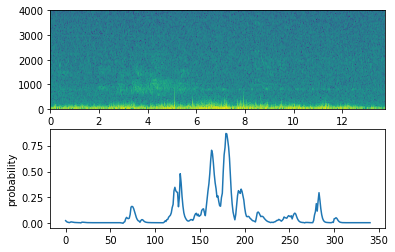

In [134]:
chime_threshold = 0.50
prediction = detect_triggerword(your_filename)
chime_on_activate(your_filename, prediction, chime_threshold)
IPython.display.Audio("./chime_output.wav")